In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
# pprevent annoying tensorflow warning
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings
warnings.simplefilter("ignore")

In [2]:
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import load_img, img_to_array

In [3]:
import pickle

In [4]:
import joblib

In [5]:
keras.backend.clear_session()

In [6]:
df=pd.read_csv(r'characters.csv')
datasets=df.groupby('dateset')
train_df=datasets.get_group('train')
test_df=datasets.get_group('test')
valid_df=datasets.get_group('valid')
print(train_df['filepaths'].iloc[0])
print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), '  valid_df length: ', len(valid_df))
print(train_df['labels'].value_counts())

train/Ryan1/63.jpg
train_df length:  773   test_df length:  80   valid_df length:  78
Ryan       395
notRyan    378
Name: labels, dtype: int64


In [7]:
# train_df is balanced, Lets look at about 30 training images and get the average height, width and aspect ratio
#to use to select an image size for the model
ryan_train_dir=r'train/ryan' # select one of the class directories in train set
flist=sorted(os.listdir(ryan_train_dir)) # get a list of the files
ht, wt, file_count = 0,0,200
plt.figure(figsize=(20,20))
for i, f in enumerate(flist): # iterate through the files
    if i >=file_count:
        break  # only lok at first file_count number of files to save time
    else: #As long as we are here might as well show 20 training images
        imgpath=os.path.join(ryan_train_dir,f)
        img=plt.imread(imgpath)
        h,w,c=np.shape(img) # use numpy shape returns height, width
        ht += h
        wt += w
        if i < 20:
            plt.subplot(4,5,i+1)
            plt.axis('off')
            plt.title(f, color='blue', fontsize=16)
            plt.imshow(img)
plt.show()
ave_h=int(ht/file_count)
ave_w=int(wt/file_count)
aspect_ratio=ave_h/ave_w
img_size=(224, int(224/aspect_ratio))
img_shape=(img_size[0], img_size[1], 3)
print('Average height= ', ave_h, '  average width= ', ave_w, ' average aspect ratio h/w= ', aspect_ratio, ' image shape: ', img_shape)

Average height=  300   average width=  300  average aspect ratio h/w=  1.0  image shape:  (224, 224, 3)


In [8]:
# create train, test and valid generators
batch_size=32 # We will use and EfficientetB3 model, with image size of (224,224) 
# I didn't have a wide array of data so I am using a lot of data augmentation here; more data would have been better
trgen=ImageDataGenerator(rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2])
t_and_v_gen=ImageDataGenerator()
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
print ('{0:^12s}{1:^12s}'.format('class name', 'class index'))
for klass, index in zip(classes, class_indices):
    print(f'{klass:^12s}{str(index):^12s}')

Found 773 validated image filenames belonging to 2 classes.
Found 78 validated image filenames belonging to 2 classes.
Found 80 validated image filenames belonging to 2 classes.
test batch size:  80   test steps:  1  number of classes :  2
 class name class index 
    Ryan         0      
  notRyan        1      


In [10]:
# create an efficientNetB3 model to use for transfer learning
img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=(img_shape), pooling='max')
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x=Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.2, seed=123)(x)
x=Dense(128, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)        
x=Dense(32, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.2, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

In [11]:
# create 2 useful callbacks, one to control the learning rate, and one to control early stopping based on validation loss
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, verbose=1,restore_best_weights=True)
callbacks=[rlronp, estop]

In [12]:
# train the model
epochs=12
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Epoch 1/12


2023-02-09 16:19:08.640834: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


25/25 [==============================] - 193s 7s/step - loss: 11.8672 - accuracy: 0.6727 - val_loss: 11.8734 - val_accuracy: 0.4744 - lr: 0.0010
Epoch 2/12
25/25 [==============================] - 183s 7s/step - loss: 10.7062 - accuracy: 0.7671 - val_loss: 10.5395 - val_accuracy: 0.6795 - lr: 0.0010
Epoch 3/12
25/25 [==============================] - 188s 8s/step - loss: 9.7714 - accuracy: 0.8215 - val_loss: 9.5518 - val_accuracy: 0.7179 - lr: 0.0010
Epoch 4/12
25/25 [==============================] - 195s 8s/step - loss: 8.9257 - accuracy: 0.8396 - val_loss: 8.7235 - val_accuracy: 0.7949 - lr: 0.0010
Epoch 5/12
25/25 [==============================] - 188s 8s/step - loss: 8.1830 - accuracy: 0.8784 - val_loss: 8.0117 - val_accuracy: 0.8590 - lr: 0.0010
Epoch 6/12
25/25 [==============================] - 183s 7s/step - loss: 7.5165 - accuracy: 0.9082 - val_loss: 7.3270 - val_accuracy: 0.8846 - lr: 0.0010
Epoch 7/12
25/25 [==============================] - 183s 7s/step - loss: 6.9745 - a

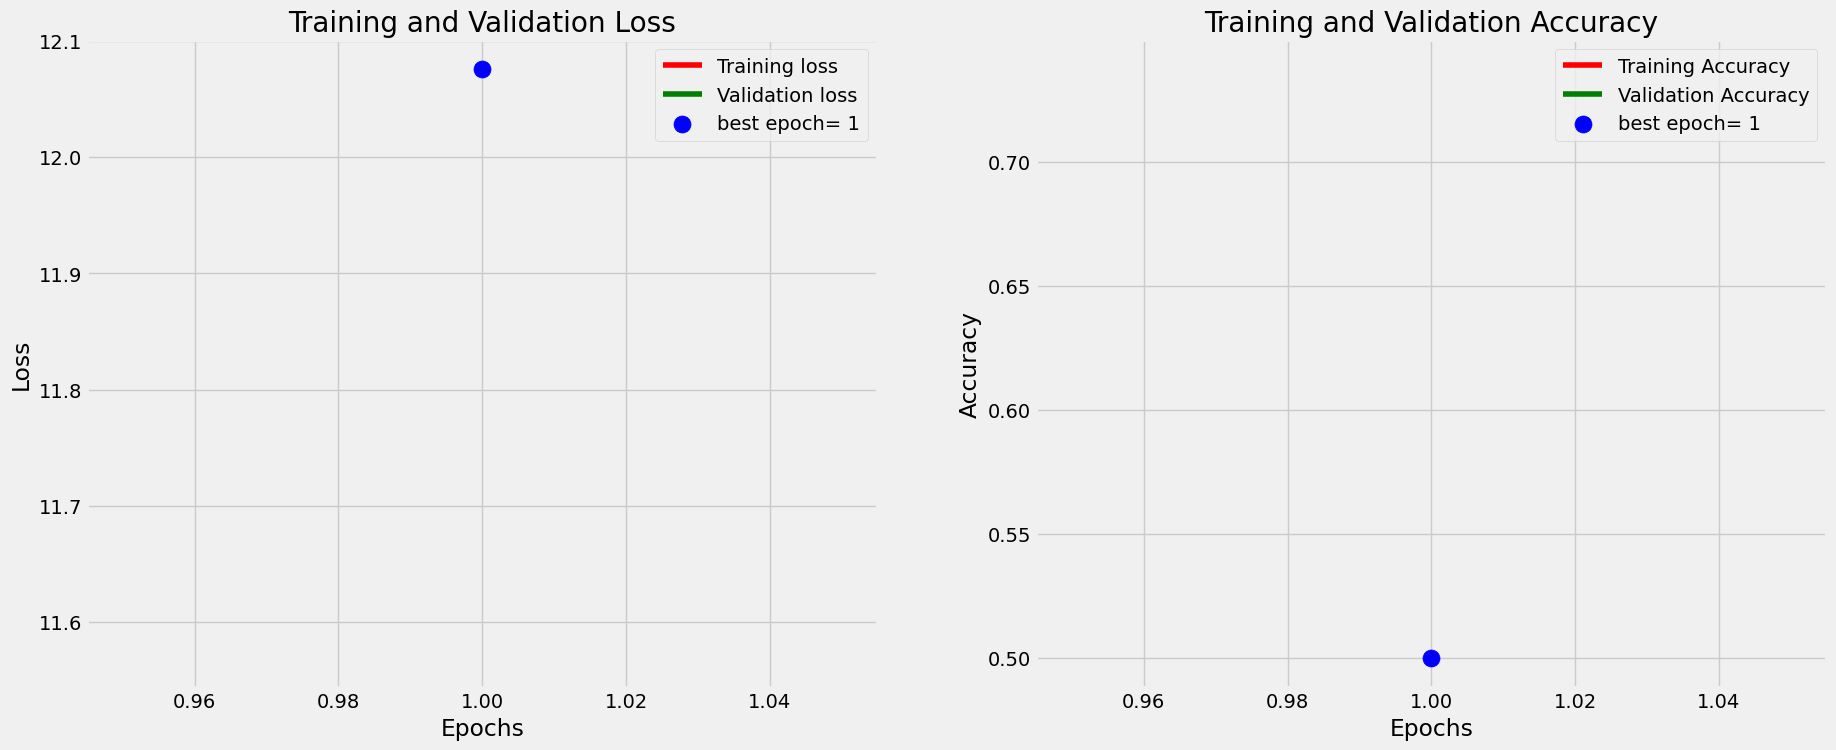

In [27]:
#define a function to plot the training data
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
tr_plot(history,0)


In [16]:
# use the trained model to make predictions and calculate accuracy since this is binary classification accuracy is sufficient
preds=model.predict(test_gen, steps=test_steps, verbose=1)
#preds=model.predict(my_image)
errors=0
for i, p in enumerate(preds):
    index=np.argmax(p)
    if class_indices[index] != labels[i]:
        errors +=1
acc= (1.0-errors/len(preds)) * 100 

print(f'There were {errors} errors in {len(preds)} trials for an accuracy of  {acc:6.2f} %')
    
    

1/1 [==============================] - 5s 5s/step
There were 4 errors in 80 trials for an accuracy of   95.00 %


In [17]:
joblib.dump(model, "model_2_9.pkl", compress=1)

['model_2_9.pkl']

In [87]:
image = load_img('train/Ryan1/15.jpg', target_size=(224, 224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)

In [66]:
model.predict(image)

1/1 [==============================] - 4s 4s/step


array([[0., 1.]], dtype=float32)

In [27]:
#lets show the images in the images to predict directory
plt.figure(figsize=(20,5))
sdir=r'test'
flist=sorted(os.listdir(sdir))
j = 0
for i,f in enumerate(flist):
    break
    fpath=os.path.join(sdir,f)
    img=plt.imread(fpath)
    plt.subplot(2,6,i +1)
    plt.axis('off')
    plt.title(f, color='blue', fontsize=16)
    plt.imshow(img)
plt.show()
    

<Figure size 2000x500 with 0 Axes>